Warning message:
: package ‘curl’ was built under R version 3.2.3Warning message:
: package ‘ggplot2’ was built under R version 3.2.3

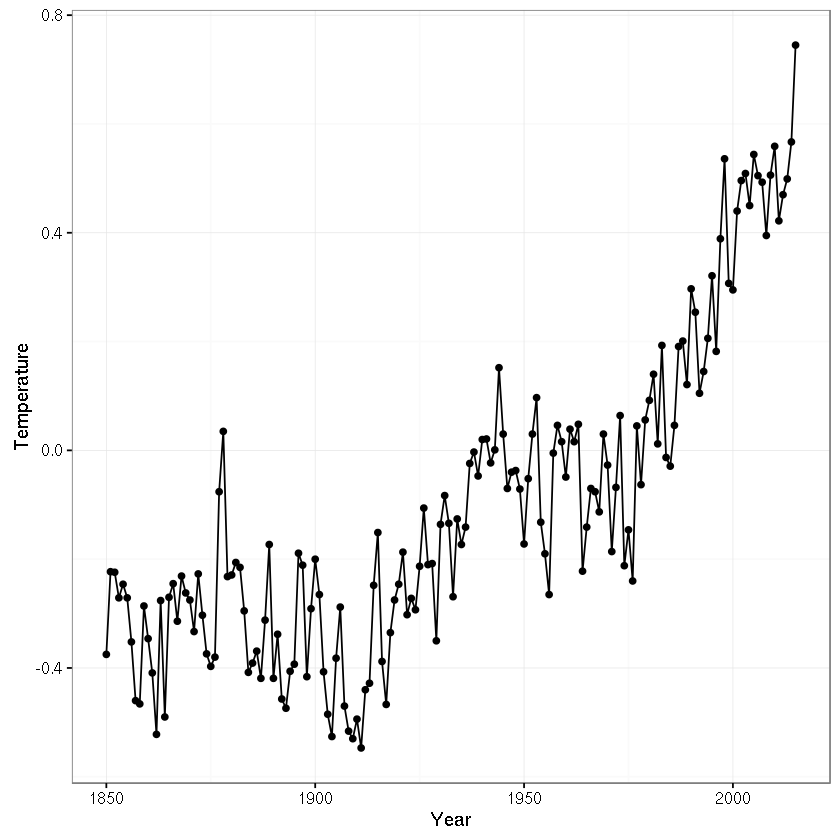

In [1]:
#
# Additive modelling global temperature time series: revisited
#
# http://www.fromthebottomoftheheap.net/2016/03/25/additive-modeling-global-temperature-series-revisited/


library("curl")
tmpf <- tempfile()
curl_download("http://www.metoffice.gov.uk/hadobs/hadcrut4/data/current/time_series/HadCRUT.4.4.0.0.annual_ns_avg.txt", tmpf)
gtemp <- read.table(tmpf, colClasses = rep("numeric", 12))[, 1:2] # only want some of the variables
names(gtemp) <- c("Year", "Temperature")


gtemp <- head(gtemp, -1)                # -1 drops the last row



library("ggplot2")
theme_set(theme_bw())
p1 <- ggplot(gtemp, aes(x = Year, y = Temperature)) +
    geom_point()
p1 + geom_line()

In [2]:
library("mgcv")

m1 <- gamm(Temperature ~ s(Year), data = gtemp, correlation = corARMA(form = ~ Year, p = 1))
m2 <- gamm(Temperature ~ s(Year), data = gtemp, correlation = corARMA(form = ~ Year, p = 2))

anova(m1$lme, m2$lme)

Loading required package: nlme
This is mgcv 1.8-9. For overview type 'help("mgcv-package")'.


,call,Model,df,AIC,BIC,logLik,Test,L.Ratio,p-value
m1$lme,"lme.formula(fixed = y ~ X - 1, data = strip.offset(mf), random = rand, correlation = correlation, weights = weights, method = method, control = control)",1,5,-277.7465,-262.1866,143.8733,,NA,NA
m2$lme,"lme.formula(fixed = y ~ X - 1, data = strip.offset(mf), random = rand, correlation = correlation, weights = weights, method = method, control = control)",2,6,-278.2519,-259.58,145.1259,1 vs 2,2.505381,0.1134581


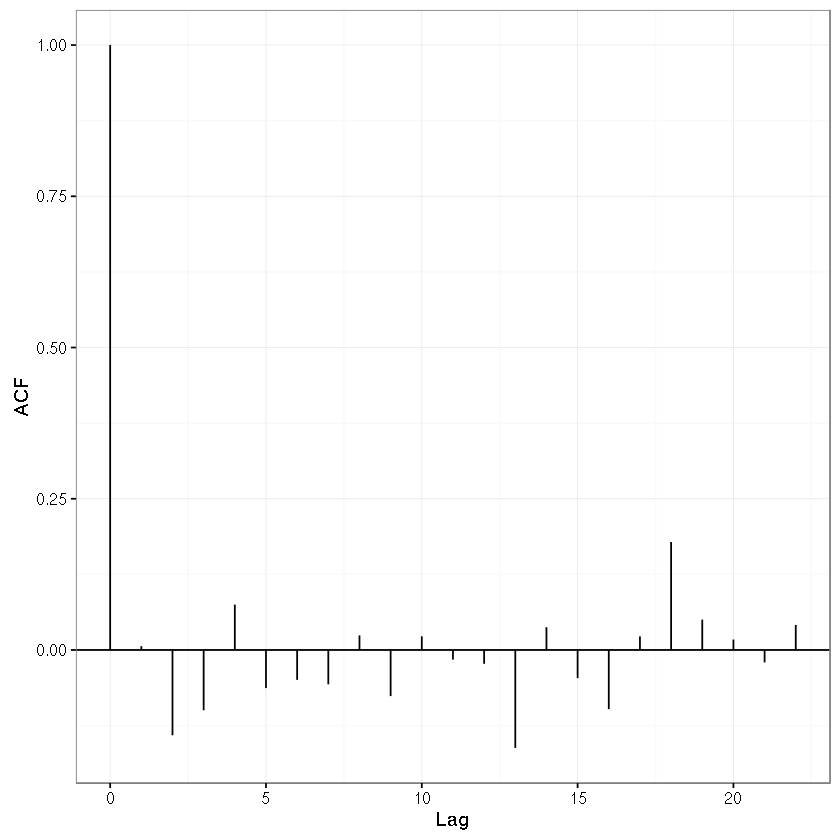

In [3]:
ACF <- acf(resid(m1$lme, type = "normalized"), plot = FALSE)
ACF <- setNames(data.frame(unclass(ACF)[c("acf", "lag")]), c("ACF","Lag"))
ggplot(ACF, aes(x = Lag, y = ACF)) +
    geom_hline(aes(yintercept = 0)) +
    geom_segment(mapping = aes(xend = Lag, yend = 0))

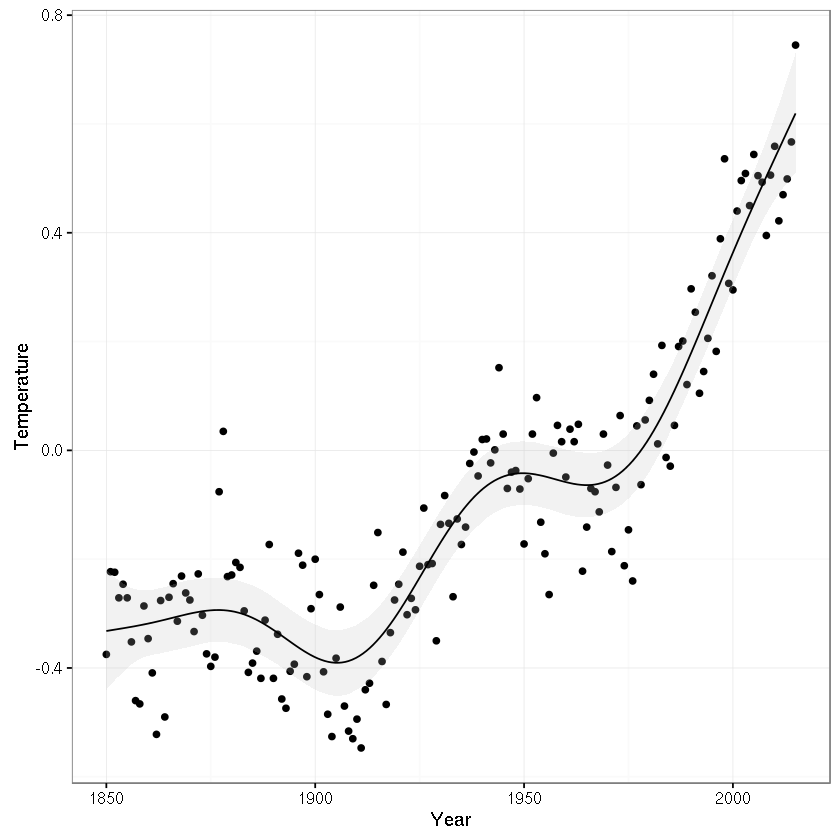

In [4]:
tmpf <- tempfile()
curl_download("https://gist.githubusercontent.com/gavinsimpson/d23ae67e653d5bfff652/raw/25fd719c3ab699e48927e286934045622d33b3bf/simulate.gamm.R", tmpf)
source(tmpf)

set.seed(10)
newd <- with(gtemp, data.frame(Year = seq(min(Year), max(Year), length.out = 200)))
sims <- simulate(m1, nsim = 10000, newdata = newd)

ci <- apply(sims, 1L, quantile, probs = c(0.025, 0.975))
newd <- transform(newd,
                  fitted = predict(m1$gam, newdata = newd),
                  lower  = ci[1, ],
                  upper  = ci[2, ])

p1 + geom_ribbon(data = newd, aes(ymin = lower, ymax = upper, x = Year, y = fitted),
                 alpha = 0.2, fill = "grey") +
    geom_line(data = newd, aes(y = fitted, x = Year))

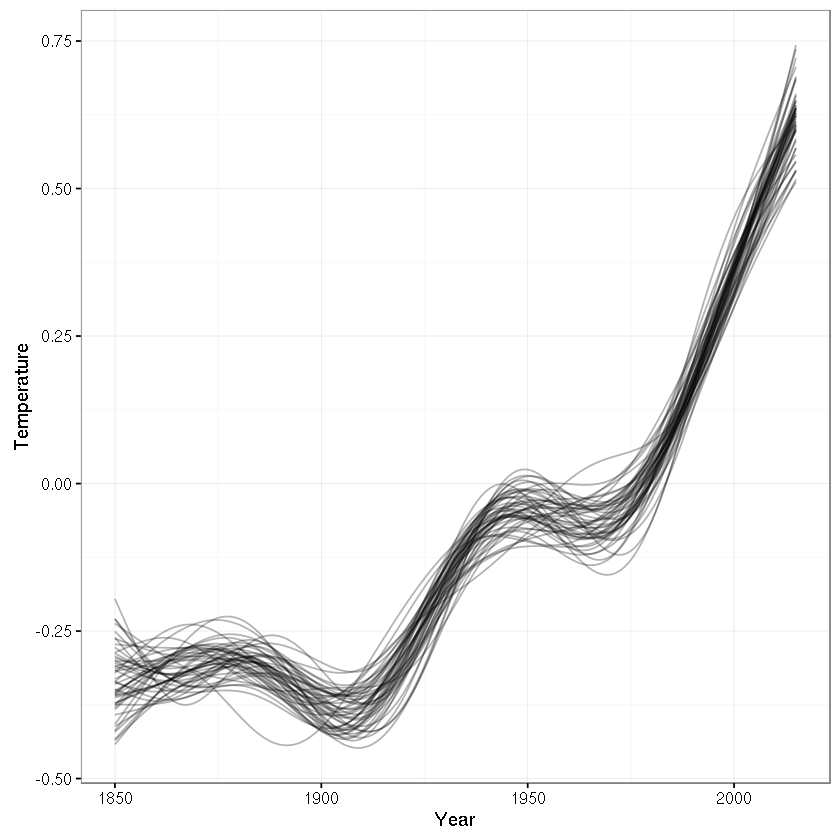

In [5]:
set.seed(42)
S <- 50
sims2 <- setNames(data.frame(sims[, sample(10000, S)]), paste0("sim", seq_len(S)))
sims2 <- setNames(stack(sims2), c("Temperature", "Simulation"))
sims2 <- transform(sims2, Year = rep(newd$Year, S))

ggplot(sims2, aes(x = Year, y = Temperature, group = Simulation)) +
    geom_line(alpha = 0.3)

Warning message:
: Removed 8750 rows containing missing values (geom_path).

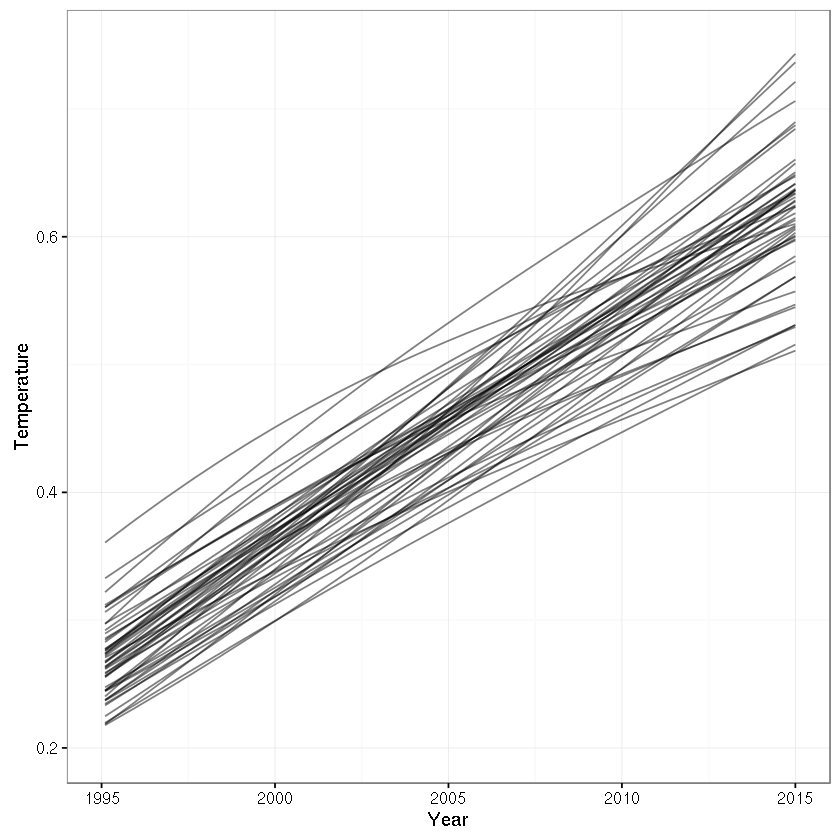

In [6]:
ggplot(sims2, aes(x = Year, y = Temperature, group = Simulation)) +
    geom_line(alpha = 0.5) + xlim(c(1995, 2015)) + ylim(c(0.2, 0.75))

Loading required package: MASS
Warning message:
: Removed 74 rows containing missing values (geom_path).Warning message:
: Removed 190 rows containing missing values (geom_path).

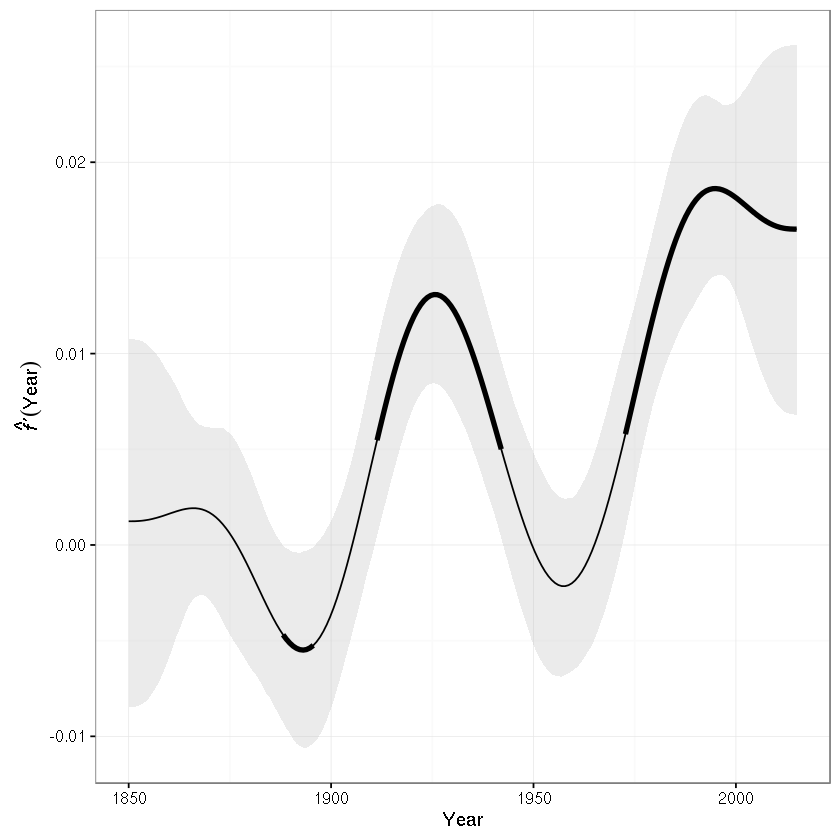

In [7]:
tmpf <- tempfile()
curl_download("https://gist.githubusercontent.com/gavinsimpson/ca18c9c789ef5237dbc6/raw/295fc5cf7366c831ab166efaee42093a80622fa8/derivSimulCI.R", tmpf)
source(tmpf)

fd <- derivSimulCI(m1, samples = 10000, n = 200)

CI <- apply(fd[[1]]$simulations, 1, quantile, probs = c(0.025, 0.975))
sigD <- signifD(fd[["Year"]]$deriv, fd[["Year"]]$deriv, CI[2, ], CI[1, ],
                eval = 0)
newd <- transform(newd,
                  derivative = fd[["Year"]]$deriv[, 1], # computed first derivative
                  fdUpper = CI[2, ],                    # upper CI on first deriv
                  fdLower = CI[1, ],                    # lower CI on first deriv
                  increasing = sigD$incr,               # where is curve increasing?
                  decreasing = sigD$decr)               # ... or decreasing?


ggplot(newd, aes(x = Year, y = derivative)) +
    geom_ribbon(aes(ymax = fdUpper, ymin = fdLower), alpha = 0.3, fill = "grey") +
    geom_line() +
    geom_line(aes(y = increasing), size = 1.5) +
    geom_line(aes(y = decreasing), size = 1.5) +
    ylab(expression(italic(hat(f) * "'") * (Year))) +
    xlab("Year")

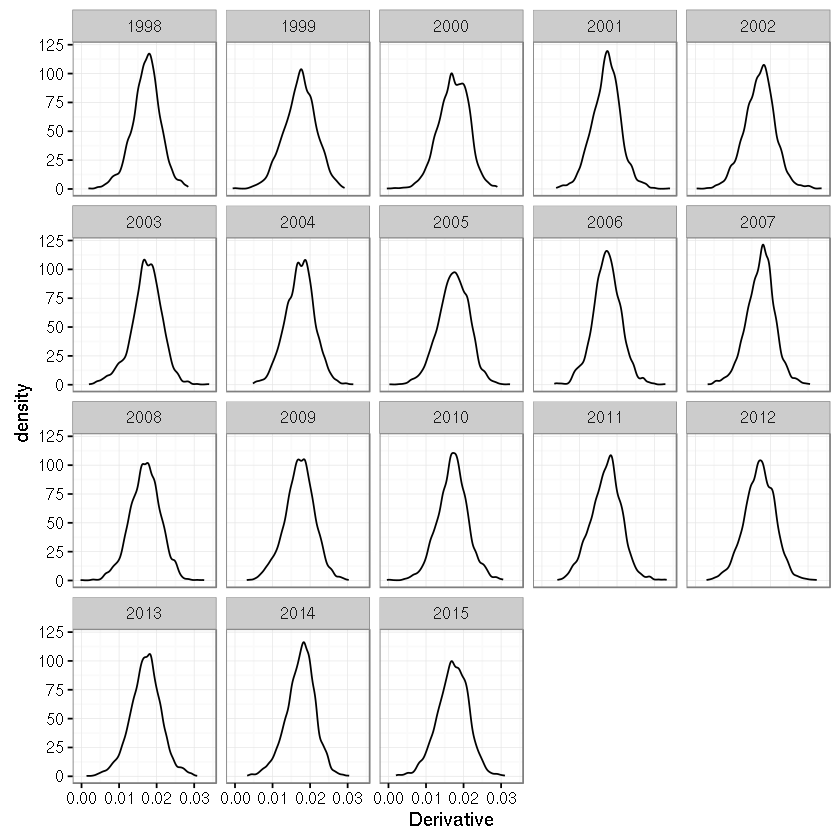

In [8]:
set.seed(123)
nsim <- 10000
pauseD <- derivSimulCI(m1, samples = nsim,
                       newdata = data.frame(Year = seq(1998, 2015, by = 1)))

annSlopes <- setNames(stack(setNames(data.frame(pauseD$Year$simulations),
                                     paste0("sim", seq_len(nsim)))),
                      c("Derivative", "Simulations"))
annSlopes <- transform(annSlopes, Year = rep(seq(1998, 2015, by = 1), each = nsim))

ggplot(annSlopes, aes(x = Derivative, group = Year)) +
    geom_line(stat = "density", trim = TRUE) + facet_wrap(~ Year)

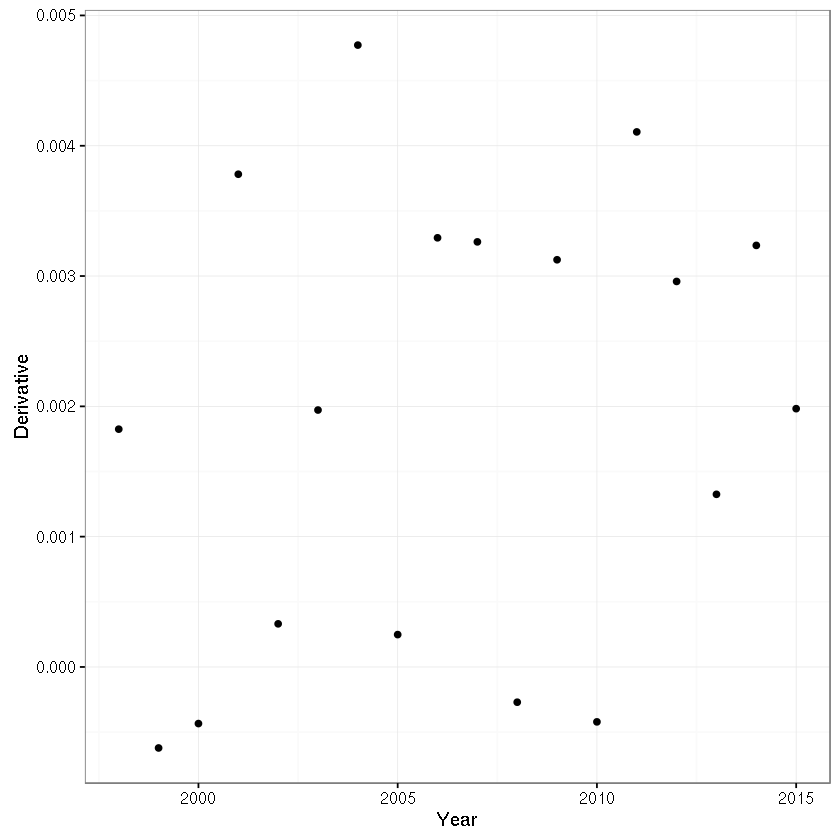

In [9]:
minD <- aggregate(Derivative ~ Year, data = annSlopes, FUN = min)
ggplot(minD, aes(x = Year, y = Derivative)) +
    geom_point()

Warning message:
: package ‘viridis’ was built under R version 3.2.4

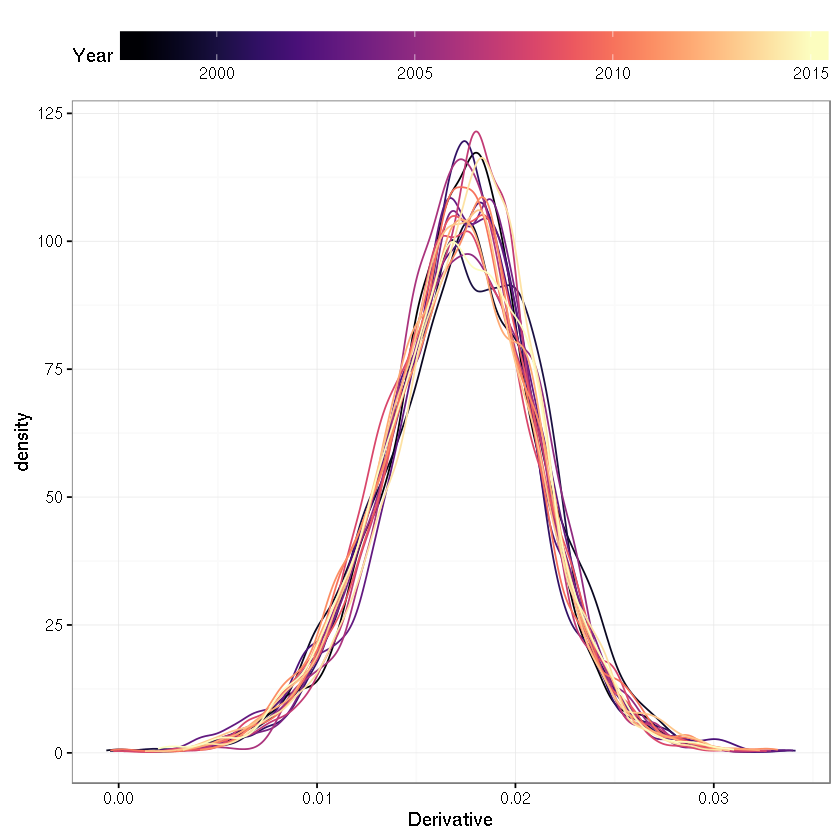

In [10]:
library("viridis")
ggplot(annSlopes, aes(x = Derivative, group = Year, colour = Year)) +
    geom_line(stat = "density", trim = TRUE) + scale_color_viridis(option = "magma") +
    theme(legend.position = "top", legend.key.width = unit(3, "cm"))